## Login Time Analysis
This notebook analyzes simulated user login timestamps by aggregating login events into 15-minute time intervals to characterize temporal demand patterns, identify daily cycles, and assess data quality issues using exploratory time-series analysis and visualization.

### Import libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Load login data from JSON

In [ ]:
with open ('/content/logins.json','r') as f:
  data = json.load(f)

df = pd.DataFrame(data)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### Convert login_time to datetime

In [ ]:
df['login_time'] = pd.to_datetime(df['login_time'])
df.dtypes

,0
login_time,datetime64[ns]


In [ ]:
# Set login_time as index
df = df.set_index('login_time')

### Aggregate login counts into 15-minute intervals
Resample the event-based data into fixed 15-minute bins and count logins per interval.

In [ ]:
df_15mins = (df
             .resample('15T')
             .size()
             .rename('login_count')
             .to_frame()
             )
df_15mins.head()

/tmp/ipython-input-3501275001.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')


,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Handling Missing Values

In [ ]:
df_15mins.isna().sum()

,0
login_count,0


### Time series visualization
This plot shows how login demand fluctuates over time at a 15-minute granularity.

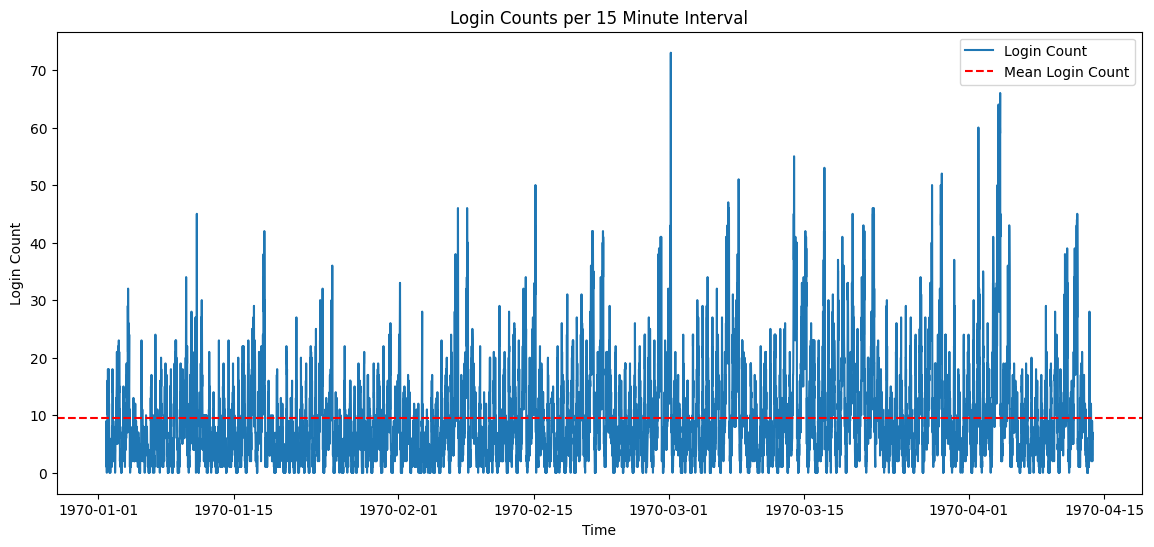

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_15mins.index, df_15mins.login_count, label='Login Count')
plt.axhline(df_15mins.login_count.mean(), color='red', linestyle='--', label='Mean Login Count')
plt.title('Login Counts per 15 Minute Interval')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.legend()
plt.show()

In [ ]:
df_15mins.login_count.median()

7.0

### Distribution of 15-minute login counts
This histogram helps characterize demand variability and burstiness.

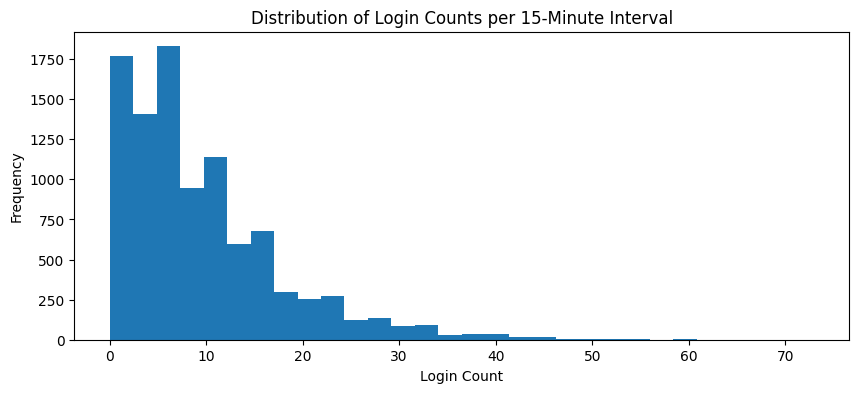

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(df_15mins.login_count, bins=30)
plt.title("Distribution of Login Counts per 15-Minute Interval")
plt.xlabel("Login Count")
plt.ylabel("Frequency")
plt.show()

### Findings & Interpretation
Login activity at a 15-minute resolution is highly variable and bursty, with an average login count slightly below 10 and a median of 7, indicating that typical intervals experience relatively moderate demand while a smaller number of high-activity intervals drive the mean upward. This gap between the mean and median reflects a right-skewed distribution, where occasional sharp spikes—sometimes exceeding 60–70 logins—represent synchronized user behavior occurring within short time windows. Overall, demand is dominated by consistent baseline activity with intermittent surges rather than uniformly high usage, suggesting that short-term peaks are an important consideration for capacity planning despite lower typical load levels.

### Extract time-of-day features
To analyze daily cycles, we extract hour and minute information.

In [ ]:
df_15mins['hour'] = df_15mins.index.hour
df_15mins['minute'] = df_15mins.index.minute
df_15mins.head()

,login_count,hour,minute
login_time,,,
1970-01-01 20:00:00,2,20,0
1970-01-01 20:15:00,6,20,15
1970-01-01 20:30:00,9,20,30
1970-01-01 20:45:00,7,20,45
1970-01-01 21:00:00,1,21,0


### Average login demand by time of day
This reveals systematic daily usage patterns.

In [ ]:
avg_daily = (
      df_15mins
      .groupby(['hour','minute'])['login_count']
      .mean()
      .reset_index()
)


In [ ]:
# Create a continuous time of day variable
avg_daily['time_of_day'] = avg_daily['hour'] + avg_daily['minute']/60
avg_daily.head()

,hour,minute,login_count,time-of_day,time_of_day
0,0,0,14.107843,0.00,0.00
1,0,15,15.166667,0.25,0.25
2,0,30,14.950980,0.50,0.50
3,0,45,14.529412,0.75,0.75
4,1,0,15.186275,1.00,1.00


### Plot average daily cycle
Visualizing the average login pattern across a typical day.

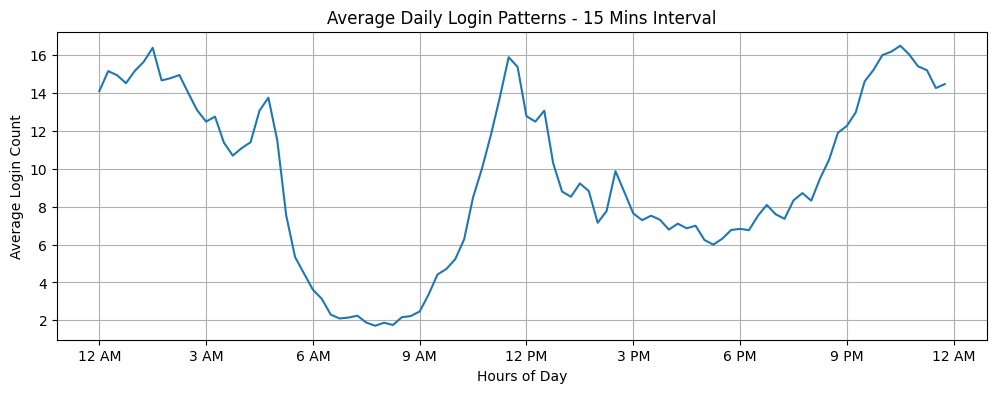

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(avg_daily.time_of_day, avg_daily.login_count)
plt.title('Average Daily Login Patterns - 15 Mins Interval')
plt.xlabel('Hours of Day')
plt.ylabel('Average Login Count')

# Creating AM/PM ticks
ticks = np.arange(0,25,3)
labels = []
for t in ticks:
    if t == 0 or t == 24:
        labels.append("12 AM")
    elif t < 12:
        labels.append(f"{int(t)} AM")
    elif t == 12:
        labels.append("12 PM")
    else:
        labels.append(f"{int(t-12)} PM")

plt.xticks(ticks, labels)
plt.grid(True)
plt.show()

### Daily 15-Minute Login Pattern - Findings & Interpretation
The average daily login pattern aggregated at 15-minute intervals reveals a strong and repeatable time-of-day cycle. Login activity is lowest during the early morning hours (approximately 4-8 AM), corresponding to typical sleep periods, followed by a sharp increase beginning in the morning as users start their day. Activity reaches a noticeable peak around midday, likely associated with lunch-time or short breaks, then moderates through the afternoon before rising again in the evening, where sustained high activity is observed between roughly 7-10 PM. This structure indicates that login demand is driven by human daily routines rather than random arrivals, with clear behavioral differences across morning, daytime, and evening periods. The consistency of this AM/PM pattern across days confirms the presence of strong daily seasonality in login behavior.

### Rolling average (trend vs noise)
A rolling mean smooths short-term noise and highlights sustained trends.

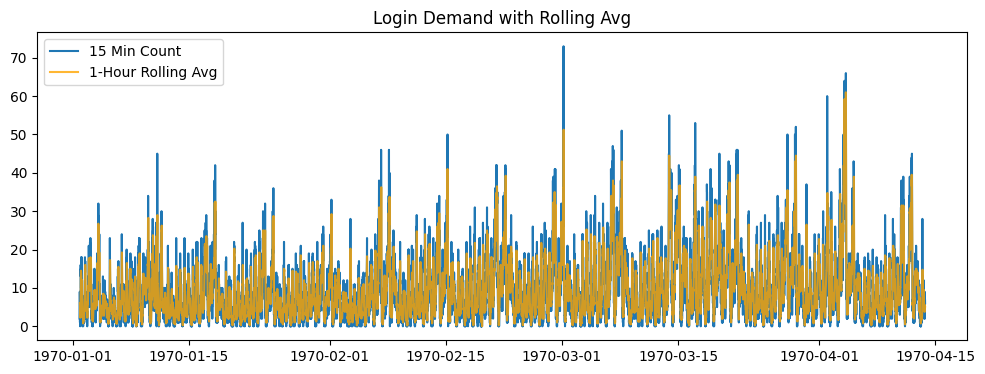

In [ ]:
df_15mins['rolling_1hr'] = df_15mins['login_count'].rolling(4).mean()

# Plot

plt.figure(figsize=(12,4))
plt.plot(df_15mins.index,df_15mins.login_count, label= '15 Min Count')
plt.plot(df_15mins.index,df_15mins.rolling_1hr, alpha=0.8,label='1-Hour Rolling Avg', color='orange')
plt.legend()
plt.title('Login Demand with Rolling Avg')
plt.show()

### Weekly Seasonality Analysis

In [ ]:
# Aggregate Daily 15 Minute login count
daily_login = df_15mins.resample('D')['login_count'].sum().to_frame()
daily_login.head()

,login_count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [ ]:
# Add weekday information
daily_login['weekday'] = daily_login.index.day_name()
daily_login.head()

,login_count,weekday
login_time,,
1970-01-01,112,Thursday
1970-01-02,681,Friday
1970-01-03,793,Saturday
1970-01-04,788,Sunday
1970-01-05,459,Monday


In [ ]:
# Average login demand by weekday
weekday_avg = (
    daily_login
    .groupby('weekday')['login_count']
    .mean()
    .reindex([
        'Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
)
weekday_avg

,login_count
weekday,
Monday,588.200000
Tuesday,662.000000
Wednesday,738.500000
Thursday,797.333333
Friday,1013.866667
Saturday,1291.800000
Sunday,1211.133333


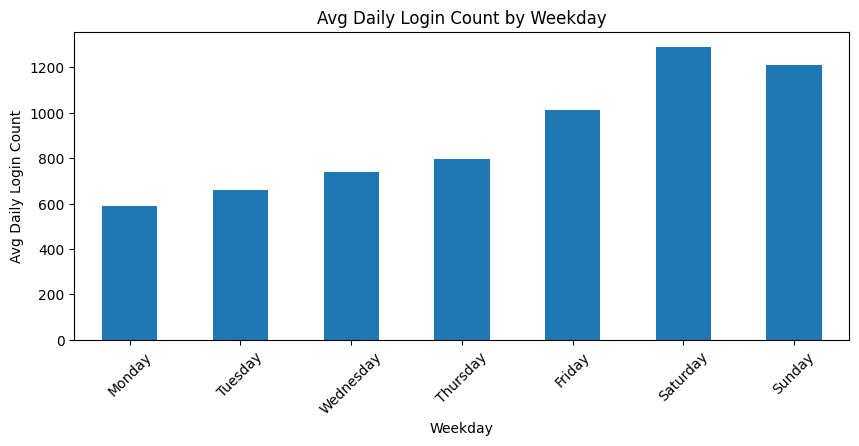

In [ ]:
# Visualize weekly seasonality

plt.figure(figsize=(10,4))
weekday_avg.plot(kind='bar')

plt.title('Avg Daily Login Count by Weekday')
plt.ylabel('Avg Daily Login Count')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.show()


### Weekly Seasonality - Findings & Interpretation
Average daily login counts exhibit a clear weekly seasonal pattern, with activity gradually increasing from Monday through Friday and peaking on the weekend. Login demand is lowest at the start of the week, rises steadily across weekdays, and reaches its highest levels on Saturday, with Sunday remaining elevated relative to weekdays. This pattern suggests that user engagement intensifies toward the end of the week and is highest during weekends, consistent with increased discretionary time and leisure-driven usage. The strong weekday-weekend contrast indicates that login behavior is influenced not only by daily routines but also by weekly cycles, reinforcing the presence of multi-scale seasonality in the data.

### Data Quality Summary
The dataset spans from January 1, 1970 to April 15, 1970 and appears to be synthetic or simulated, as indicated by its epoch-anchored date range and unusually clean temporal structure. While absolute calendar interpretations are not meaningful, the data exhibits internally consistent timing with no missing intervals after aggregation, making it well-suited for exploratory time-series analysis of short-term variability, daily cycles, and weekly patterns. Zero-login intervals represent genuine periods of low activity rather than missing data.

## Summary of Findings
Aggregating login events into 15-minute intervals reveals a highly variable and bursty demand pattern, with an average login count slightly below 10 and a median of 7, indicating right-skewed behavior driven by short-lived spikes. Clear daily seasonality is observed, with lowest activity in the early morning hours, a midday increase, and sustained evening peaks, reflecting human daily routines. In addition, weekly seasonality is present, with login activity increasing through the week and peaking on weekends, particularly on Saturday, suggesting higher engagement during non-working days.